### Decision Tree Classifier fitted by cross validation

 1. Clean the data: Add target variable and remove redundant variable
 2. Cross validation over train+validation set combined, choose optimal model in termos of 0-1 loss for different size trees
 3. Measure accuracy over test set and AUC

### Load train, val and test sets for binary class and multiclass

In [1]:
import numpy as np
import pandas as pd
import os

os.chdir('/Users/bwilliams/GoogleDrive/UniversityOfHelsinki/Fall2020/IML/TeamProject/TermProjectIML/bin')
from SplitData import *


### Fit binary classification DT

Accuracy on Train: 0.8932038834951457
Cross validation Accuracy:  0.8297619047619047 {'max_depth': 2}


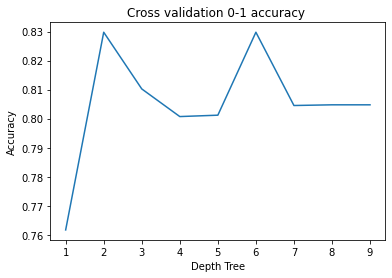

Accuracy on Test: 0.8076923076923077


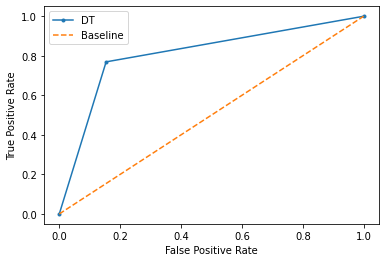

In [2]:
#####################################

from sklearn import tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics

# https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
parameters = {'max_depth':range(1,10)}
clf = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), parameters, n_jobs=4, cv=10)
clf.fit(X=X_trainval, y=y_trainval_bin)
tree_model = clf.best_estimator_

y_pred_train = tree_model.predict(X_trainval)

print("Accuracy on Train:",metrics.accuracy_score(y_trainval_bin, y_pred_train))

print ('Cross validation Accuracy: ', clf.best_score_, clf.best_params_) 

cv_accuracy = clf.cv_results_['mean_test_score']
plt.plot(range(1,10) ,cv_accuracy)
plt.title('Cross validation 0-1 accuracy ')
plt.xlabel('Depth Tree')
plt.ylabel('Accuracy')
plt.show()

y_pred = tree_model.predict(X_test)
# probabilities of class event
y_pred_proba = tree_model.predict_proba(X_test)[:,0]

print("Accuracy on Test:",metrics.accuracy_score(y_test_bin, y_pred))

y_test_01 = pd.get_dummies(y_test_bin)['event']

fpr, tpr, thresholds = metrics.roc_curve(y_test_01, y_pred_proba)
metrics.auc(fpr, tpr)

plt.plot(fpr,tpr , marker='.', label='DT')
plt.plot(fpr, fpr, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


### Tree visualization binary class

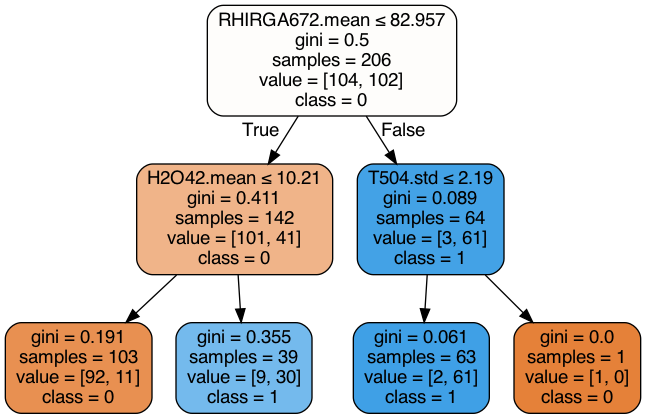

In [3]:
# Tree visualization
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

feature_cols = X_trainval.columns
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('data/tree1.png')
Image(graph.create_png())



### Multiclass classification DT

Accuracy on Train: 0.6553398058252428
Cross validation Accuracy:  0.6121428571428572 {'max_depth': 2}


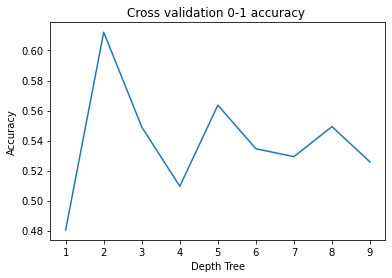

Accuracy on Test: 0.5961538461538461


In [4]:
#####################################

from sklearn import tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics

# https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
parameters = {'max_depth':range(1,10)}
clf = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), parameters, n_jobs=4, cv=10)
clf.fit(X=X_trainval, y=y_trainval)
tree_model = clf.best_estimator_

y_pred_train = tree_model.predict(X_trainval)

print("Accuracy on Train:",metrics.accuracy_score(y_trainval, y_pred_train))

print ('Cross validation Accuracy: ', clf.best_score_, clf.best_params_) 

cv_accuracy = clf.cv_results_['mean_test_score']
plt.plot(range(1,10) ,cv_accuracy)
plt.title('Cross validation 0-1 accuracy ')
plt.xlabel('Depth Tree')
plt.ylabel('Accuracy')
plt.show()

y_pred = tree_model.predict(X_test)
# probabilities of class event
y_pred_proba = tree_model.predict_proba(X_test)[:,0]

print("Accuracy on Test:",metrics.accuracy_score(y_test, y_pred))


### Confusion matrix and decision tree

The confusion matrix shows that a 2 level decision tree classifes all observations into **nonevent** or into **lb**. By looking at the tree plot, we can see that at most a 2 level tree can classify into 3 classes. And the class lf lI is unlikely to be classified, because very few observations in training got into that leaf node. 

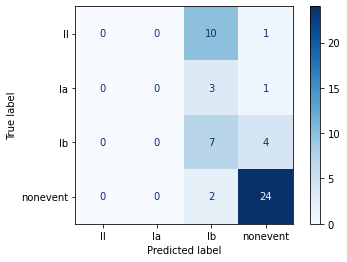

In [5]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(tree_model, X_test, y_test,
                                 # display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 # normalize='true'
                                 )


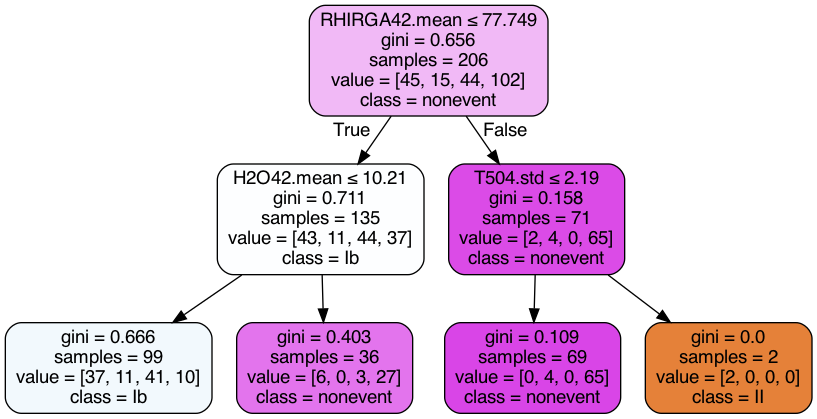

In [13]:
# Tree visualization
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
feature_cols = X_trainval.columns
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names = sorted(y_trainval.unique()))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('data/tree1.png')
Image(graph.create_png())
